In [1]:
from pymongo import MongoClient
client = MongoClient('localhost', 27017)
db = client['test_database']
tab = db['test_table']

In [2]:
from pymongo import MongoClient
from bs4 import BeautifulSoup
from collections import Counter

import warnings
import pprint
import copy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')
import matplotlib.patches as mpatches
import requests
import json
import re
import unicodedata
import string

from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
from nltk.util import ngrams

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import roc_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, precision_score, recall_score

from os import path
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [3]:
debate1_url = 'https://www.politico.com/story/2016/09/full-transcript-first-2016-presidential-debate-228761'
debate2_url = 'https://www.politico.com/story/2016/10/2016-presidential-debate-transcript-229519'
debate3_url = 'https://www.politico.com/story/2016/10/full-transcript-third-2016-presidential-debate-230063'

r = requests.get(debate1_url)
r2 = requests.get(debate2_url)
r3 = requests.get(debate3_url)


In [4]:
db = client.metroid
pages = db.pages
pages.insert_one({'html': r.content})
soup = BeautifulSoup(r.content, "html")

pages2 = db.pages2
pages2.insert_one({'html': r2.content})
soup2 = BeautifulSoup(r2.content, "html")

pages3 = db.pages3
pages3.insert_one({'html': r3.content})
soup3 = BeautifulSoup(r3.content, "html")

In [5]:
div = soup.find("div", {"class": "global-wrapper"})
main = div.find("main", {"class": "super-duper"})
article = main.find("article", {"class": "story-main-content"})
text = article.find("div", {"class": "story-text"})

div2 = soup2.find("div", {"class": "global-wrapper"})
main2 = div2.find("main", {"class": "super-duper"})
article2 = main2.find("article", {"class": "story-main-content"})
text2 = article2.find("div", {"class": "story-text"})

div3 = soup3.find("div", {"class": "global-wrapper"})
main3 = div3.find("main", {"class": "super-duper"})
article3 = main3.find("article", {"class": "story-main-content"})
text3 = article3.find("div", {"class": "story-text"})

In [6]:
rows = text.find_all('p')[2:-1]
all_rows = []
empty_row = {
    "Speaker":None, "Line":None
}
for i, row in enumerate(rows):
    new_row = copy.copy(empty_row)
    if rows[i].find('b') != None:
        a = rows[i].find('b').text
        new_row['Speaker'] = a
    elif rows[i].find('b') == None:
        new_row['Speaker'] = a
    new_row['Line'] = rows[i].text
    all_rows.append(new_row)
    
for i in all_rows:
    if i['Line'] == '(APPLAUSE)':
        i['Speaker'] = 'AUDIENCE'
        i['Line'] = 'Applause'
    if i['Line'][:5] == 'HOLT:':
        i['Line'] = i['Line'][5:]
    if i['Line'][:8] == 'CLINTON:':
        i['Line'] = i['Line'][8:]
    if i['Line'][:6] == 'TRUMP:':
        i['Line'] = i['Line'][6:]
        
for row in all_rows:
    pages.insert_one(row)
    
rows = pages.find()
debate1 = pd.DataFrame(list(rows))
debate1 = debate1.drop(['_id', 'html'], axis = 1)
debate1 = debate1[2:]

debate1 = debate1[debate1['Line'] != 'Advertisement']
debate1.index = range(len(debate1))
debate1 = debate1[:444]

In [80]:
rows2 = text2.find_all('p')[2:-1]
all_rows2 = []
empty_row2 = {
    "Speaker":None, "Line":None
}
for i, row in enumerate(rows2):
    new_row2 = copy.copy(empty_row2)
    if rows2[i].find('b') != None:
        a = rows2[i].find('b').text
        new_row2['Speaker'] = a
    elif rows2[i].find('b') == None:
        new_row2['Speaker'] = a
    new_row2['Line'] = rows2[i].text
    all_rows2.append(new_row2)
    
for i in all_rows2:
    if i['Line'] == '[Applause]':
        i['Speaker'] = 'AUDIENCE'
        i['Line'] = 'Applause'
    if i['Line'][:8] == 'Raddatz:':
        i['Line'] = i['Line'][8:]
    if i['Line'][:7] == 'Cooper:':
        i['Line'] = i['Line'][7:]
    if i['Line'][:6] == 'Brock:':
        i['Line'] = i['Line'][6:]
    if i['Line'][:8] == 'Clinton:':
        i['Line'] = i['Line'][8:]
    if i['Line'][:6] == 'Trump:':
        i['Line'] = i['Line'][6:]
        
for row in all_rows2:
    pages2.insert_one(row)
    
rows2 = pages2.find()
debate2 = pd.DataFrame(list(rows2))
debate2 = debate2.drop(['_id', 'html'], axis = 1)
debate2 = debate2[4:]
debate2 = debate2[debate2['Line'] != 'Advertisement']
debate2.index = range(len(debate2))
debate2 = debate2[:206]

In [81]:
rows3 = text3.find_all('p')[2:-1]
all_rows3 = []
empty_row3 = {
    "Speaker":None, "Line":None
}
for i, row in enumerate(rows3):
    new_row3 = copy.copy(empty_row3)
    if rows3[i].find('b') != None:
        a = rows3[i].find('b').text
        new_row3['Speaker'] = a
    elif rows3[i].find('b') == None:
        new_row3['Speaker'] = a
    new_row3['Line'] = rows3[i].text
    all_rows3.append(new_row3)
    
for i in all_rows3:
    if i['Line'] == '(Applause)':
        i['Speaker'] = 'AUDIENCE'
        i['Line'] = 'APPLAUSE'
    if i['Line'][:14] == 'Chris Wallace:':
        i['Line'] = i['Line'][14:]
    if i['Line'][:8] == 'Wallace:':
        i['Line'] = i['Line'][8:]
    if i['Line'][:7] == 'Cooper:':
        i['Line'] = i['Line'][7:]
    if i['Line'][:6] == 'Brock:':
        i['Line'] = i['Line'][6:]
    if i['Line'][:8] == 'Clinton:':
        i['Line'] = i['Line'][8:]
    if i['Line'][:6] == 'Trump:':
        i['Line'] = i['Line'][6:]
        
for row in all_rows3:
    pages3.insert_one(row)
    
rows3 = pages3.find()
debate3 = pd.DataFrame(list(rows3))
debate3 = debate3.drop(['_id', 'html'], axis = 1)
debate3 = debate3[1:]
debate3 = debate3[debate3['Line'] != 'Advertisement']
debate3.index = range(len(debate3))
debate3 = debate3[:257]
debate3['Speaker'][0] = 'Wallace'

In [82]:
all_debates = debate1.append(debate2).append(debate3)
debate = all_debates.copy()

In [83]:
name_lower = []
for i in debate['Speaker']:
    name_lower.append(i.lower())
debate['Speaker'] = name_lower

In [89]:
debate.index = range(len(debate))

In [91]:
debate[debate['Speaker'] == 'audience']

,Speaker,Line
5,audience,APPLAUSE
7,audience,APPLAUSE
9,audience,APPLAUSE
196,audience,APPLAUSE
477,audience,APPLAUSE
828,audience,APPLAUSE
834,audience,APPLAUSE


In [100]:
debate_cand = debate[(debate['Speaker'] == 'trump') | (debate['Speaker'] == 'clinton')]

In [103]:
bools = []
for i in debate_cand['Speaker']:
    if i == 'clinton':
        bools.append(1)
    else:
        bools.append(0)
debate_cand['Labels'] = bools

/Users/kevinpark/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [108]:
vectorizer = TfidfVectorizer(stop_words='english', max_features = 600)
ps = PorterStemmer()
def preprocess(arr):
    '''
    removes puncuation from reviews, puts in lower case
    '''
    REPLACE_NO_SPACE = re.compile("[.;:!\'?,\"()\[\]]")
    REPLACE_WITH_SPACE = re.compile("(<br\s*/><br\s*/>)|(\-)|(\/)")
    reviews = [REPLACE_NO_SPACE.sub("", line.lower()) for line in arr]
    reviews = [REPLACE_WITH_SPACE.sub(" ", line) for line in arr]
    return reviews

def stemmer(arr):
    '''
    takes a corpus in an array and returns a simillar arr of stemmed words
    '''
    output = list()
    for text in arr:
        current = ""
        for word in text.split():
            current += ps.stem(word) + " "
        output.append(current)
    return output

def pipeline(arr):
    step1 = preprocess(arr)
    step2 = stemmer(step1)
    step3 = vectorizer.fit_transform(np.array(step2))
    return step3

In [109]:
vectors = pipeline(debate_cand['Line'])
vector_pd = pd.DataFrame(vectors.toarray(), columns = vectorizer.get_feature_names())
X_train, X_test, y_train, y_test = train_test_split(vector_pd, debate_cand['Labels'])

In [111]:
nb = MultinomialNB()
nb.fit(vector_pd, debate_cand['Labels'])

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [112]:
y_pred_class = nb.predict(X_test)
y_prob = nb.predict_proba(X_test)

In [113]:
from sklearn import metrics
metrics.accuracy_score(y_test, y_pred_class)

0.8516129032258064

In [117]:
lr = LogisticRegression()
lr.fit(vectors, debate_cand['Labels'])
lr_pred_class = lr.predict(X_test)
lr_prob = lr.predict_proba(X_test)

In [118]:
metrics.accuracy_score(y_test, lr_pred_class)

0.8580645161290322

In [114]:
def calculate_threshold_values(prob, y):
    '''
    Build dataframe of the various confusion-matrix ratios by threshold
    from a list of predicted probabilities and actual y values
    '''
    df = pd.DataFrame({'prob': prob, 'y': y})
    df.sort_values('prob', inplace=True)
    
    actual_p = df.y.sum()
    actual_n = df.shape[0] - df.y.sum()

    df['tn'] = (df.y == 0).cumsum()
    df['fn'] = df.y.cumsum()
    df['fp'] = actual_n - df.tn
    df['tp'] = actual_p - df.fn

    df['fpr'] = df.fp/(df.fp + df.tn)
    df['tpr'] = df.tp/(df.tp + df.fn)
    df['precision'] = df.tp/(df.tp + df.fp)
    df = df.reset_index(drop=True)
    return df
    
def plot_roc(ax, df):
    ax.plot([1]+list(df.fpr), [1]+list(df.tpr), label="ROC")
    ax.plot([0,1],[0,1], 'k', label="random")
    ax.set_xlabel('fpr')
    ax.set_ylabel('tpr')
    ax.set_title('ROC Curve')
    ax.legend()
    
def plot_precision_recall(ax, df):
    ax.plot(df.tpr,df.precision, label='precision/recall')
    #ax.plot([0,1],[0,1], 'k')
    ax.set_xlabel('recall')
    ax.set_ylabel('precision')
    ax.set_title('Precision/Recall Curve')
    ax.plot([0,1],[df.precision[0],df.precision[0]], 'k', label='random')
    ax.set_xlim(xmin=0,xmax=1)
    ax.set_ylim(ymin=0,ymax=1)

In [122]:
debate

,Speaker,Line
0,holt,Good evening from Hofstra University in Hemps...
1,holt,The participants tonight are Donald Trump and ...
2,holt,The 90-minute debate is divided into six segme...
3,holt,The questions are mine and have not been share...
4,holt,"I will invite you to applaud, however, at this..."
...,...,...
902,wallace,"This is a final time, probably to both of you..."
903,clinton,Well I would like to say to everyone watching...
904,wallace,"Secretary Clinton, thank you. Mr. Trump?"
905,trump,She's raising the money from the people she w...


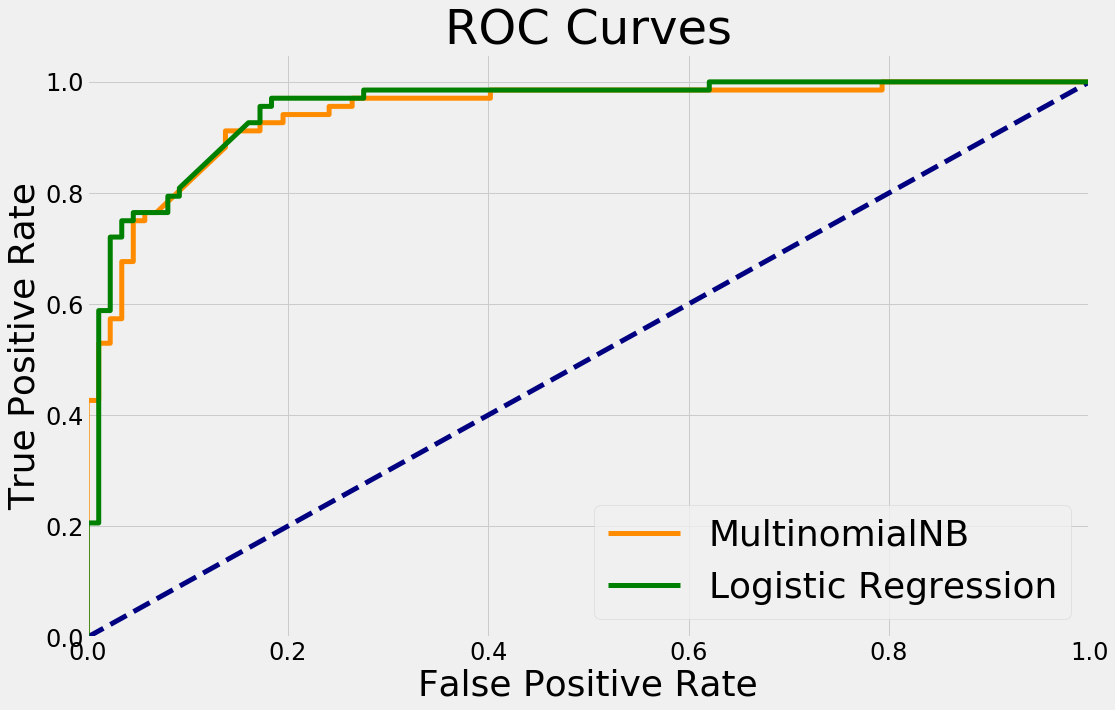

In [121]:
fpr = dict()
tpr = dict()

roc_auc = dict()

for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(y_test, y_prob[:,1])
    
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_pred_class.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

lpr = dict()
ipr = dict()
loc_auc = dict()
for i in range(2):
    lpr[i], ipr[i], _ = roc_curve(y_test, lr_prob[:,1])
    
lpr["micro"], ipr["micro"], _ = roc_curve(y_test.ravel(), y_pred_class.ravel())
loc_auc["micro"] = auc(lpr["micro"], ipr["micro"])

plt.figure(figsize = (16,10))
lw = 5
plt.plot(fpr[1], tpr[1], color='darkorange',
         lw=lw, label='MultinomialNB')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.xticks(fontsize = 24)
plt.yticks(fontsize = 24)
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize = 36)
plt.ylabel('True Positive Rate', fontsize = 36)
plt.title('ROC Curves', fontsize = 48)
plt.plot(lpr[1], ipr[1], color='green',
         lw=lw, label='Logistic Regression')
plt.legend(loc="lower right", fontsize= 36)
plt.show()

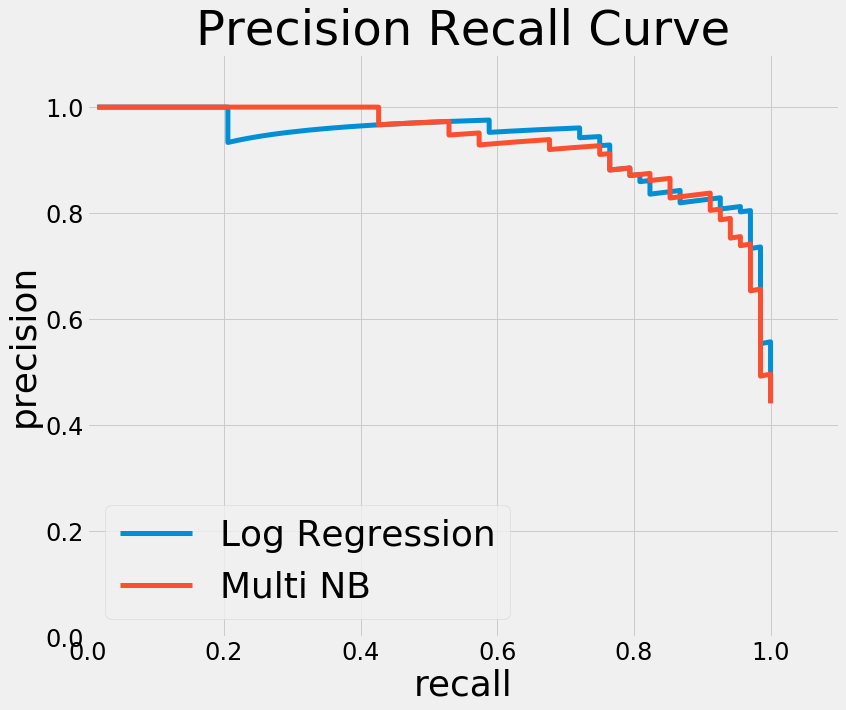

In [124]:
df = calculate_threshold_values(lr_prob[:,1], y_test)
df1 = calculate_threshold_values(y_prob[:,1], y_test)
fig, ax = plt.subplots(figsize = (12, 10))
ax.plot(df.tpr,df.precision, linewidth = 5, label = 'Log Regression')
    #ax.plot([0,1],[0,1], 'k')
ax.set_xlabel('recall', fontsize = 36)
ax.set_ylabel('precision', fontsize = 36)
#ax.plot([0,1],[df.precision[0],df.precision[0]], 'k', label = 'random', linewidth = 3)
ax.set_xlim(xmin=0,xmax=1)
ax.set_ylim(ymin=0,ymax=1)
plt.xticks(fontsize = 24)
plt.yticks(fontsize = 24)
ax.set_title('Precision Recall Curve', fontsize=48)

ax.plot(df1.tpr,df1.precision, linewidth = 5, label = 'Multi NB')
ax.set_xlim(xmin=0,xmax=1.1)
ax.set_ylim(ymin=0,ymax=1.1)
ax.legend(fontsize = 36)